In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import factorial

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)


## Erlang-C Implementation

Queuing theory model to calculate call center metrics.


In [25]:
def erlang_c(num_agents, traffic):
    if num_agents <= 0 or traffic <= 0:
        return 0.0
    
    if traffic >= num_agents:
        return 1.0
    
    n = int(num_agents)
    a = traffic
    
    erlang_b_numerator = (a ** n) / factorial(n)
    erlang_b_denominator = sum([(a ** k) / factorial(k) for k in range(n)])
    erlang_b_denominator += erlang_b_numerator * (n / (n - a))
    
    probability_wait = erlang_b_numerator * (n / (n - a)) / erlang_b_denominator
    
    return probability_wait


def calculate_asa(num_agents, traffic, aht_seconds):
    prob_wait = erlang_c(num_agents, traffic)
    
    if num_agents <= traffic:
        return float('inf')
    
    asa = (prob_wait * aht_seconds) / (num_agents - traffic)
    return asa


def calculate_occupancy(num_agents, traffic):
    if num_agents <= 0:
        return 1.0
    return traffic / num_agents


def calculate_service_level(num_agents, traffic, aht_seconds, target_seconds=20):
    prob_wait = erlang_c(num_agents, traffic)
    
    if num_agents <= traffic:
        return 0.0
    
    service_level = 1 - prob_wait * np.exp(-(num_agents - traffic) * target_seconds / aht_seconds)
    return service_level


print("Erlang-C functions ready")


Erlang-C functions ready


## Testing


In [26]:
test_scenarios = [
    {"agents": 20, "calls_per_hour": 100, "aht_seconds": 180},
    {"agents": 30, "calls_per_hour": 200, "aht_seconds": 180},
    {"agents": 50, "calls_per_hour": 500, "aht_seconds": 180}
]

for i, scenario in enumerate(test_scenarios, 1):
    agents = scenario["agents"]
    calls_per_hour = scenario["calls_per_hour"]
    aht_seconds = scenario["aht_seconds"]
    
    traffic = (calls_per_hour / 3600) * aht_seconds
    
    pw = erlang_c(agents, traffic)
    asa = calculate_asa(agents, traffic, aht_seconds)
    occ = calculate_occupancy(agents, traffic)
    sl = calculate_service_level(agents, traffic, aht_seconds)
    
    print(f"Scenario {i}: {agents} agents, {calls_per_hour} calls/hr, {aht_seconds}s AHT")
    print(f"  Traffic: {traffic:.2f} | P(wait): {pw:.2%} | ASA: {asa:.1f}s | Occ: {occ:.1%} | SL: {sl:.1%}\n")


Scenario 1: 20 agents, 100 calls/hr, 180s AHT
  Traffic: 5.00 | P(wait): 0.00% | ASA: 0.0s | Occ: 25.0% | SL: 100.0%

Scenario 2: 30 agents, 200 calls/hr, 180s AHT
  Traffic: 10.00 | P(wait): 0.00% | ASA: 0.0s | Occ: 33.3% | SL: 100.0%

Scenario 3: 50 agents, 500 calls/hr, 180s AHT
  Traffic: 25.00 | P(wait): 0.00% | ASA: 0.0s | Occ: 50.0% | SL: 100.0%



## Visualizations


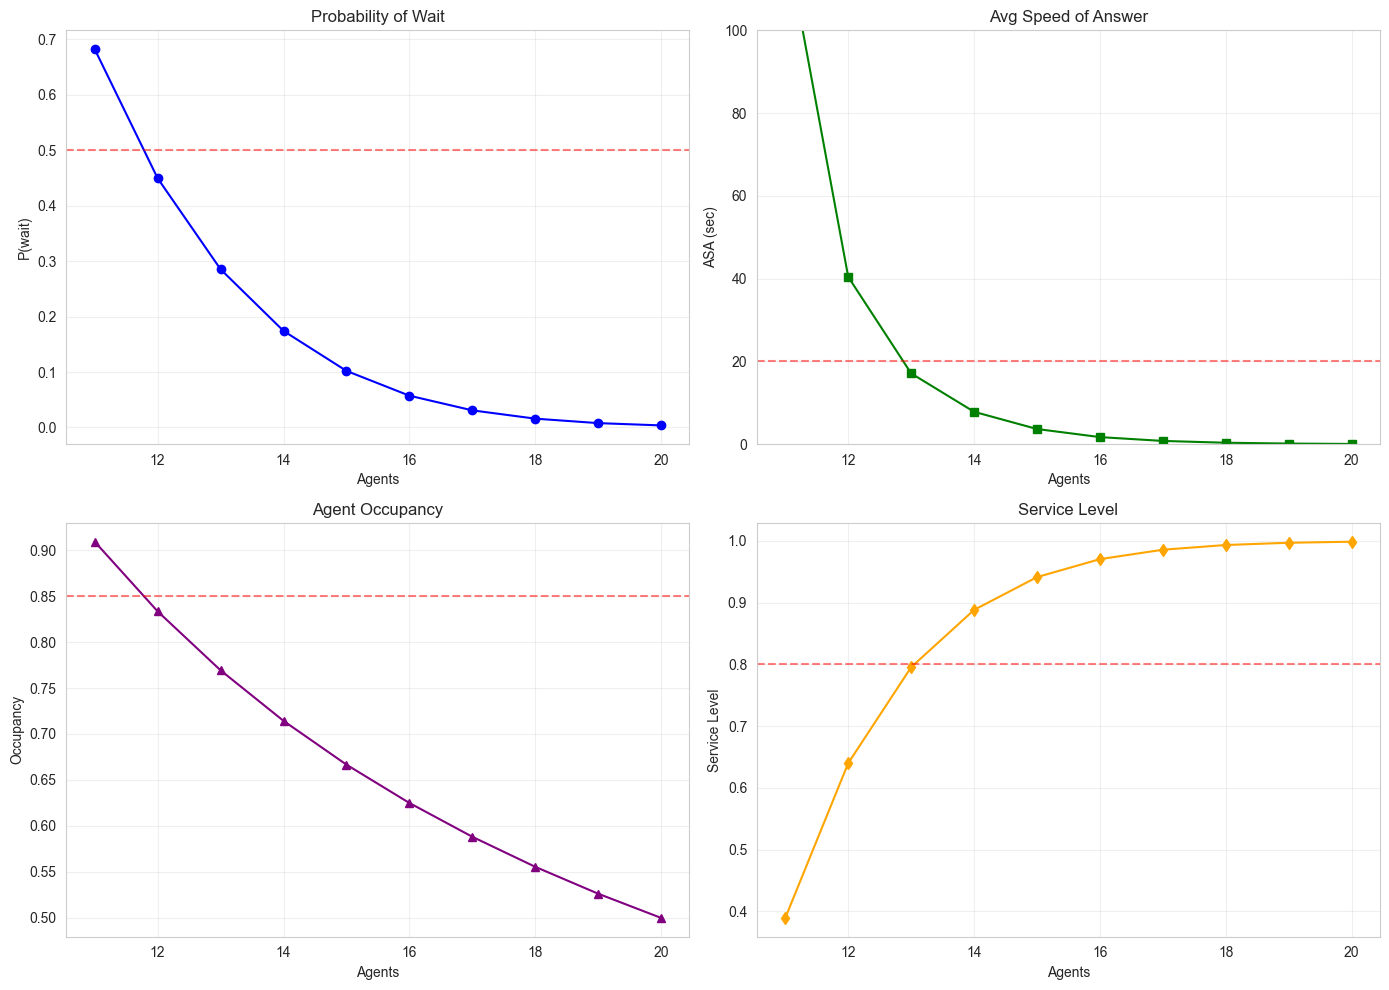

In [27]:
calls_per_hour = 200
aht_seconds = 180
traffic = (calls_per_hour / 3600) * aht_seconds

agent_range = range(int(traffic) + 1, int(traffic * 2) + 1)

prob_wait = []
avg_asa = []
occupancy = []
service_level = []

for agents in agent_range:
    prob_wait.append(erlang_c(agents, traffic))
    avg_asa.append(calculate_asa(agents, traffic, aht_seconds))
    occupancy.append(calculate_occupancy(agents, traffic))
    service_level.append(calculate_service_level(agents, traffic, aht_seconds))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.plot(agent_range, prob_wait, 'b-', marker='o')
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('Agents')
ax1.set_ylabel('P(wait)')
ax1.set_title('Probability of Wait')
ax1.grid(True, alpha=0.3)

ax2.plot(agent_range, avg_asa, 'g-', marker='s')
ax2.axhline(y=20, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Agents')
ax2.set_ylabel('ASA (sec)')
ax2.set_title('Avg Speed of Answer')
ax2.set_ylim([0, min(100, max(avg_asa))])
ax2.grid(True, alpha=0.3)

ax3.plot(agent_range, occupancy, 'purple', marker='^')
ax3.axhline(y=0.85, color='r', linestyle='--', alpha=0.5)
ax3.set_xlabel('Agents')
ax3.set_ylabel('Occupancy')
ax3.set_title('Agent Occupancy')
ax3.grid(True, alpha=0.3)

ax4.plot(agent_range, service_level, 'orange', marker='d')
ax4.axhline(y=0.80, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Agents')
ax4.set_ylabel('Service Level')
ax4.set_title('Service Level')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Graphs show diminishing returns - performance improves quickly initially, then levels off. Around 12-14 agents is the sweet spot for this scenario.


## Optimization

Find minimum agents that meet constraints (SL ≥ 80%, Occ ≤ 85%).


In [28]:
def find_optimal_agents(calls_per_hour, aht_seconds, 
                        service_level_target=0.80, 
                        max_occupancy=0.85):
    traffic = (calls_per_hour / 3600) * aht_seconds
    
    min_agents = int(np.ceil(traffic)) + 1
    max_agents = int(traffic * 3)
    
    for agents in range(min_agents, max_agents):
        occ = calculate_occupancy(agents, traffic)
        sl = calculate_service_level(agents, traffic, aht_seconds)
        
        if sl >= service_level_target and occ <= max_occupancy:
            asa = calculate_asa(agents, traffic, aht_seconds)
            return {
                'agents': agents,
                'traffic': traffic,
                'service_level': sl,
                'asa': asa,
                'occupancy': occ
            }
    
    return None


### Results


In [29]:
scenarios = [
    {"calls": 100, "aht": 180, "name": "Low Volume"},
    {"calls": 200, "aht": 180, "name": "Medium Volume"},
    {"calls": 500, "aht": 180, "name": "High Volume"},
    {"calls": 300, "aht": 240, "name": "High Volume + Long Calls"}
]

print("OPTIMIZATION RESULTS")
print("Constraints: Service Level ≥ 80%, Occupancy ≤ 85%\n")

results_list = []

for scenario in scenarios:
    result = find_optimal_agents(scenario["calls"], scenario["aht"])
    
    if result:
        results_list.append({
            'Scenario': scenario["name"],
            'Calls/Hour': scenario["calls"],
            'AHT (sec)': scenario["aht"],
            'Traffic': f"{result['traffic']:.2f}",
            'Agents Needed': result['agents'],
            'Service Level': f"{result['service_level']:.1%}",
            'Occupancy': f"{result['occupancy']:.1%}",
            'ASA (sec)': f"{result['asa']:.1f}"
        })

results_df = pd.DataFrame(results_list)
print(results_df.to_string(index=False))


OPTIMIZATION RESULTS
Constraints: Service Level ≥ 80%, Occupancy ≤ 85%

                Scenario  Calls/Hour  AHT (sec) Traffic  Agents Needed Service Level Occupancy ASA (sec)
              Low Volume         100        180    5.00              8         88.0%     62.5%      10.0
           Medium Volume         200        180   10.00             14         88.8%     71.4%       7.8
             High Volume         500        180   25.00             30         85.7%     83.3%       9.0
High Volume + Long Calls         300        240   20.00             25         86.2%     80.0%      10.0


Results show agents scale sub-linearly with volume (efficiency from pooling). Occupancy stays near 85% limit, service levels exceed targets due to integer constraints.


## Real Data Application


In [30]:
def parse_time_to_seconds(time_str):
    if isinstance(time_str, str):
        parts = list(map(int, time_str.split(":")))
        return parts[0] * 3600 + parts[1] * 60 + parts[2]
    return 150

df = pd.read_csv("../data/raw/call-center-data-v2-daily.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Talk Duration (sec)'] = df['Talk Duration (AVG)'].apply(parse_time_to_seconds)

recent_data = df.tail(30).copy()

print(f"Loaded {len(df)} days, using last 30 for analysis\n")
print(recent_data[['Date', 'Incoming Calls', 'Talk Duration (sec)']].head())


Loaded 1247 days, using last 30 for analysis

           Date  Incoming Calls  Talk Duration (sec)
1217 2025-05-02             215                  186
1218 2025-05-03             153                  155
1219 2025-05-04              39                  222
1220 2025-05-05             336                  176
1221 2025-05-06             238                  173


In [31]:
staffing_plan = []

for idx, row in recent_data.iterrows():
    daily_calls = row['Incoming Calls']
    aht = row['Talk Duration (sec)']
    
    calls_per_hour = daily_calls / 8
    
    optimal = find_optimal_agents(calls_per_hour, aht)
    
    if optimal:
        staffing_plan.append({
            'Date': row['Date'],
            'Daily Calls': daily_calls,
            'AHT (sec)': aht,
            'Agents': optimal['agents'],
            'Service Level': optimal['service_level'],
            'Occupancy': optimal['occupancy']
        })

staffing_df = pd.DataFrame(staffing_plan)

print(f"Days: {len(staffing_df)}")
print(f"Avg agents: {staffing_df['Agents'].mean():.1f} (min: {staffing_df['Agents'].min()}, max: {staffing_df['Agents'].max()})")
print(f"Avg SL: {staffing_df['Service Level'].mean():.1%} | Avg Occ: {staffing_df['Occupancy'].mean():.1%}\n")
print(staffing_df[['Date', 'Daily Calls', 'Agents']].head(10).to_string(index=False))


Days: 5
Avg agents: 3.2 (min: 3, max: 4)
Avg SL: 83.0% | Avg Occ: 48.0%

      Date  Daily Calls  Agents
2025-05-02          215       3
2025-05-05          336       4
2025-05-06          238       3
2025-05-14          235       3
2025-05-30          211       3


### Plots


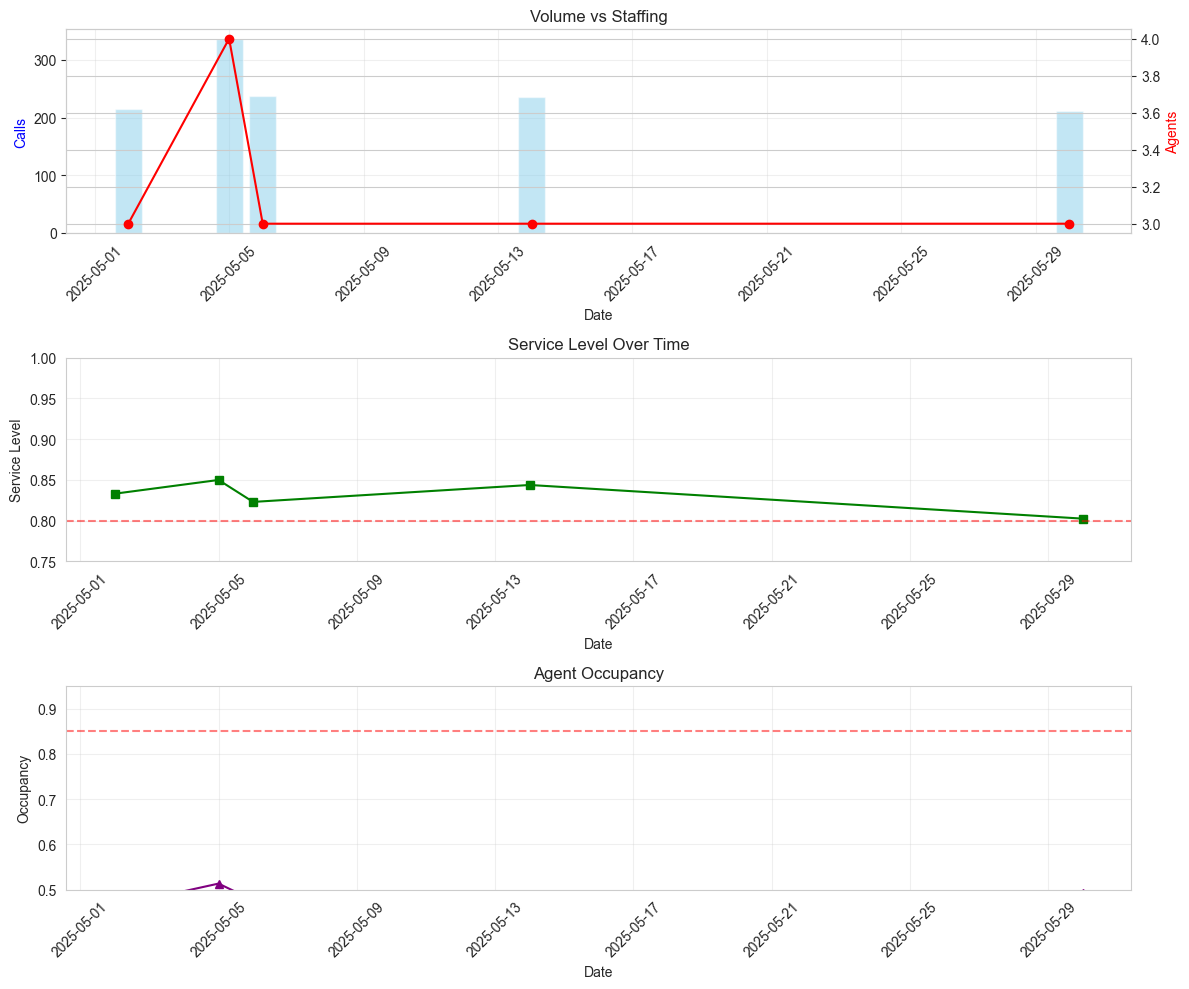

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

ax1_twin = ax1.twinx()
ax1.bar(staffing_df['Date'], staffing_df['Daily Calls'], alpha=0.5, color='skyblue')
ax1_twin.plot(staffing_df['Date'], staffing_df['Agents'], 'r-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Calls', color='blue')
ax1_twin.set_ylabel('Agents', color='red')
ax1.set_title('Volume vs Staffing')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

ax2.plot(staffing_df['Date'], staffing_df['Service Level'], 'g-', marker='s')
ax2.axhline(y=0.80, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Date')
ax2.set_ylabel('Service Level')
ax2.set_title('Service Level Over Time')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim([0.75, 1.0])
ax2.grid(True, alpha=0.3)

ax3.plot(staffing_df['Date'], staffing_df['Occupancy'], 'purple', marker='^')
ax3.axhline(y=0.85, color='red', linestyle='--', alpha=0.5)
ax3.set_xlabel('Date')
ax3.set_ylabel('Occupancy')
ax3.set_title('Agent Occupancy')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylim([0.5, 0.95])
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Staffing tracks volume, all days meet SL target, occupancy stays below 85% limit.


## Sensitivity Analysis


In [33]:
test_calls = 200
test_aht = 180

service_targets = [0.70, 0.75, 0.80, 0.85, 0.90]
occupancy_limits = [0.75, 0.80, 0.85, 0.90, 0.95]

print("Test 1: Varying Service Level Target")
print(f"{test_calls} calls/hr, {test_aht}s AHT, 85% max occ\n")

sl_results = []
for target in service_targets:
    result = find_optimal_agents(test_calls, test_aht, 
                                 service_level_target=target, 
                                 max_occupancy=0.85)
    if result:
        sl_results.append({
            'Target SL': f"{target:.0%}",
            'Agents': result['agents'],
            'Actual SL': f"{result['service_level']:.1%}",
            'Occupancy': f"{result['occupancy']:.1%}"
        })

sl_df = pd.DataFrame(sl_results)
print(sl_df.to_string(index=False))

print("\n\nTest 2: Varying Occupancy Limit")
print(f"{test_calls} calls/hr, {test_aht}s AHT, 80% SL\n")

occ_results = []
for limit in occupancy_limits:
    result = find_optimal_agents(test_calls, test_aht, 
                                 service_level_target=0.80, 
                                 max_occupancy=limit)
    if result:
        occ_results.append({
            'Max Occupancy': f"{limit:.0%}",
            'Agents': result['agents'],
            'Actual Occ': f"{result['occupancy']:.1%}",
            'Service Level': f"{result['service_level']:.1%}"
        })

occ_df = pd.DataFrame(occ_results)
print(occ_df.to_string(index=False))


Test 1: Varying Service Level Target
200 calls/hr, 180s AHT, 85% max occ

Target SL  Agents Actual SL Occupancy
      70%      13     79.6%     76.9%
      75%      13     79.6%     76.9%
      80%      14     88.8%     71.4%
      85%      14     88.8%     71.4%
      90%      15     94.1%     66.7%


Test 2: Varying Occupancy Limit
200 calls/hr, 180s AHT, 80% SL

Max Occupancy  Agents Actual Occ Service Level
          75%      14      71.4%         88.8%
          80%      14      71.4%         88.8%
          85%      14      71.4%         88.8%
          90%      14      71.4%         88.8%
          95%      14      71.4%         88.8%


Occupancy constraint is binding for this scenario (test 1 shows same agents across SL targets). Tighter constraints require more agents (test 2). Trade-off between cost and service/workload.
